## US Election 2020 Twitter Sentiment Analysis 

There are plenty of existing population polls trying to predict the outcome of a Presidential election. It would be of interest to perform ML sentiment analysis of a sample of past Twitter feeds (before it became X) to see how accurate it would be. Of course it begs the question if the sample population in Twitter has a diverse representation. On the other hand, the same can be said of the traditional polls and whether their samples are also diverse. 

#### Dataset 
I am using the [US Election 2020 Sample Dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data) from Kaggle for this analysis. It consists of two CSV files totaling about 1.7 million rows, one with Tweets focused on Joe Biden, and the other on Donald Trump. The dataset needs to be culled of Tweets originating outside of the US. While that doesn’t guarantee that non-US citizens in the US are Tweeting (or that citizens outside of the US are Tweeting) it helps narrow down any international opinions that would skew the results. The rest would be just data cleaning, for example, removing hashtags/mentions, URLs, and any extraneous text that is not generally readable and that may not convert to useful tokens. However, there some tools exist to help with data cleaning as well.

#### Tools 
As of late there are several publicly available LLMs that can assist with sentiment analysis, specifically on Twitter/X data. I'd like to explore the use of Hugging Face's [Twitter roBERTa-base Sentiment Analysis module](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest).

In [ ]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
from tqdm import tqdm    # Shows progress bar for long tasks

# Hugging Face Modules
from transformers import pipeline

# Allows for more efficent data processing
# by converting from DataFrame to Dataset
from datasets import Dataset    
import torch

---
### Data Wrangling
#### Reading in datasets

In [2]:
# Reading Trump Dataset 
trump = pd.read_csv("input/hashtag_donaldtrump.csv", lineterminator='\n')

In [3]:
# Reading Biden Dataset 
biden = pd.read_csv("input/hashtag_joebiden.csv", lineterminator='\n') 

---
#### Exploratory Data Analysis

In [4]:
trump.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [5]:
# Show size of the Trump dataset
print(trump.shape)

# Display all the columns in the DataFrame 
print(trump.columns)

(970919, 21)
Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')


In [6]:
# Show distribution of non-null features
trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            970919 non-null  object 
 1   tweet_id              970919 non-null  float64
 2   tweet                 970919 non-null  object 
 3   likes                 970919 non-null  float64
 4   retweet_count         970919 non-null  float64
 5   source                970043 non-null  object 
 6   user_id               970919 non-null  float64
 7   user_name             970897 non-null  object 
 8   user_screen_name      970919 non-null  object 
 9   user_description      869651 non-null  object 
 10  user_join_date        970919 non-null  object 
 11  user_followers_count  970919 non-null  float64
 12  user_location         675957 non-null  object 
 13  lat                   445719 non-null  float64
 14  long                  445719 non-null  float64
 15  

In [7]:
biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [8]:
# Show size of the Biden dataset
print(biden.shape)

# Display all the columns in the DataFrame 
print(biden.columns)

(776886, 21)
Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')


Add a column to differentiate tweets from Trump and Biden datasets before we combine them.

In [9]:
# Create a new column 'candidate' to differentiate 
# between tweets of Trump and Biden upon concatination 
trump['candidate'] = 'trump'

# Biden dataframe 
biden['candidate'] = 'biden'

# Combine the dataframes 
tweets_df = pd.concat([trump, biden]) 
tweets_df = tweets_df.reset_index(drop=True)

# Final data shape 
print('Final Data Shape :', tweets_df.shape) 

# View the first few rows 
print("\nFirst few rows:") 
print(tweets_df.head(3)) 

Final Data Shape : (1747805, 22)

First few rows:
            created_at      tweet_id  \
0  2020-10-15 00:00:01  1.316529e+18   
1  2020-10-15 00:00:01  1.316529e+18   
2  2020-10-15 00:00:02  1.316529e+18   

                                               tweet  likes  retweet_count  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...    0.0            0.0   
1  Usa 2020, Trump contro Facebook e Twitter: cop...   26.0            9.0   
2  #Trump: As a student I used to hear for years,...    2.0            1.0   

             source      user_id           user_name user_screen_name  \
0         TweetDeck  360666534.0  El Sol Latino News  elsollatinonews   
1  Social Mediaset   331617619.0             Tgcom24  MediasetTgcom24   
2   Twitter Web App    8436472.0              snarke           snarke   

                                    user_description  ...  \
0  🌐 Noticias de interés para latinos de la costa...  ...   
1  Profilo ufficiale di Tgcom24: tutte le notizie...  ...   


In [10]:
# Show info on combined tweet dataset
tweets_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747805 entries, 0 to 1747804
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   created_at            1747805 non-null  object 
 1   tweet_id              1747805 non-null  float64
 2   tweet                 1747805 non-null  object 
 3   likes                 1747805 non-null  float64
 4   retweet_count         1747805 non-null  float64
 5   source                1746216 non-null  object 
 6   user_id               1747805 non-null  float64
 7   user_name             1747758 non-null  object 
 8   user_screen_name      1747805 non-null  object 
 9   user_description      1564528 non-null  object 
 10  user_join_date        1747805 non-null  object 
 11  user_followers_count  1747805 non-null  float64
 12  user_location         1219049 non-null  object 
 13  lat                   801012 non-null   float64
 14  long                  801012 non-n

In [11]:
# Validate we have the Trump column set properly
tweets_df[tweets_df['candidate'] == 'trump'].head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,trump


In [12]:
# Validate we have the Biden column set properly
tweets_df[tweets_df['candidate'] == 'biden'].head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
970919,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,biden
970920,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,biden
970921,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,biden
970922,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,biden
970923,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,biden


Show distribution of tweets by `country` location.

In [13]:
# Seeing the various countries of tweets
pd.set_option('display.max_rows', 500)  # Display all rows
print(tweets_df['country'].value_counts())

country
United States of America            332495
United States                        61905
United Kingdom                       58051
India                                40091
Germany                              35379
France                               35299
Canada                               27805
Italy                                20076
Australia                            14899
Mexico                               10903
Turkey                               10368
The Netherlands                       9587
Brazil                                8735
Pakistan                              8597
Spain                                 7252
Ireland                               5452
Netherlands                           5279
Colombia                              4425
Argentina                             4404
Venezuela                             4333
Chile                                 3844
Belgium                               3823
Nigeria                               3810
Ban

---
#### Data Cleaning and Wrangling

While this dataset has quite a number of null values depending on the column, let's see if we can maximize the useful data without dropping ALL rows with null values. First let's update all USA country fields to show "US". Then, find where the `user_location` is specified, but the `country` is not (`state_code` also is missing in many rows). We will focus on users where stated location is somewhere in the USA with the assumption that this will be part of our voting and/or influence group (even though there's no way to tell whether any user is a US citizen or not, and some users aren't even necessarily individuals but represent organizations, or even bots). Sometimes users will input a city and state (or even 'USA') in the `user_location` field which we may be able to parse even if the `country` field is null.

For easier manipulation, we will change rows with various `country` names for USA to just "US". 

In [14]:
# Shorten any United States (/of America) to simply "US"
tweets_df['country'] = tweets_df['country'].replace({'United States of America': "US",'United States': "US"}) 

Filter rows to show only tweets where country field is US.

In [15]:
# Isolate tweets where `country` is "US"
tweets_cntryUSA = tweets_df[tweets_df["country"] == "US"]
tweets_cntryUSA.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,US,North America,Florida,FL,2020-10-21 00:00:00,trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,US,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,US,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,trump
5,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,...,"Perris,California",33.782519,-117.228648,NaN,US,North America,California,CA,2020-10-21 00:00:01.866082651,trump
7,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",...,"Ohio, USA",40.225357,-82.688140,NaN,US,North America,Ohio,OH,2020-10-21 00:00:02.612515712,trump


Filter full tweet DF for rows where `country` is null but `user_location` is set. This way we can try to parse out tweet user locations that are still in the USA.

In [16]:
# Check to see where user_location is available, but no country specified
tweets_loconly = tweets_df[tweets_df['country'].isnull() & 
                           tweets_df['user_location'].notnull()]
tweets_loconly['user_location'].head(10)

6                     Powell, TN
14       USA - Land of the FREE!
21                  Mother Earth
26                    Everywhere
28                  WASherst, PA
37                       Danmark
47                  Mother Earth
51           #BlueWave USA 🌊🌊🌊🌊🌊
70    37°12'28.3"N 115°57'25.9"W
82               Chula Vista, CA
Name: user_location, dtype: object

Parse `user_location` (again, where `country` is null) for US state abbreviations at the end.

In [40]:
# Read in list of US State abbreviations to parse user_location
states = pd.read_csv("support/states.csv", names=['states'])
statelist = states['states'].tolist()
print(statelist)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'USA']


In [18]:
# Filter the rows that have country as null but location as filled for those
# that have the last two characters matching a State abbreviation
user_states = tweets_loconly[tweets_loconly['user_location'].\
                             str[-2:].isin(statelist)]

In [19]:
user_states['user_location'].head(10)

6             Powell, TN
28          WASherst, PA
82       Chula Vista, CA
89        New Castle, IN
124             Davie,FL
148      Chula Vista, CA
189    Olmsted Falls, OH
218      Chula Vista, CA
260         Lawrence, MA
311      Chula Vista, CA
Name: user_location, dtype: object

Some `user_location` rows indicate "USA" so let's parse for that too.

In [20]:
# Check if user_location indicates "USA" if no state abbreviation at the end
user_stateUSA = tweets_loconly[tweets_loconly['user_location'].\
                               str.contains("USA", na=False)]

In [21]:
user_stateUSA['user_location'].head(10)

14        USA - Land of the FREE!
51            #BlueWave USA 🌊🌊🌊🌊🌊
83            #BlueWave USA 🌊🌊🌊🌊🌊
101                 NorthWest USA
102                 NorthWest USA
133           #BlueWave USA 🌊🌊🌊🌊🌊
170           #BlueWave USA 🌊🌊🌊🌊🌊
177           #BlueWave USA 🌊🌊🌊🌊🌊
255    USA, the GREATEST Country!
274                   Chicago USA
Name: user_location, dtype: object

Show distribution of users across their stated "USA" location.

In [22]:
user_stateUSA['user_location'].value_counts()

user_location
NorthWest USA                            764
#BlueWave USA 🌊🌊🌊🌊🌊                      536
California USA                           379
N.E USA                                  276
The South-USA                            223
                                        ... 
Rochester, NH, USA                         1
South Standing Rock, USA                   1
La Plasha (USA)                            1
Free Range, USA - Can't Follow             1
420 Beech Ave, Madison, TN 37115, USA      1
Name: count, Length: 2118, dtype: int64

Check if there are any rows that have `country` set but with null `user_location`.

In [23]:
# Check to see where country is available, but no user_location specified
tweets_cntryonly = tweets_df[tweets_df['user_location'].isnull() & 
                             tweets_df['country'].notnull()]
tweets_cntryonly.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate


Seeing none, now let's combine `tweets_cntryUSA` with other parsed location-only tweets.

In [ ]:
# Combine DFs with "US" country, and those with no country but US locations.
user_USAonly = pd.concat([tweets_cntryUSA, user_states, user_stateUSA]) 
user_USAonly = user_USAonly.reset_index(drop=True)

# Make sure to fill null 'country' fields with "US"
user_USAonly['country'] = user_USAonly['country'].fillna(value="US")
print(f"New size of filtered DF: {user_USAonly.shape}")

New size of filtered DF: (435522, 22)


Now we have a bit over 435 thousand tweets for our final sentiment dataset which includes users with stated locations in the USA.

In [25]:
user_USAonly.head(10)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,US,North America,Florida,FL,2020-10-21 00:00:00,trump
1,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,US,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump
2,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,US,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,trump
3,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,...,"Perris,California",33.782519,-117.228648,NaN,US,North America,California,CA,2020-10-21 00:00:01.866082651,trump
4,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",...,"Ohio, USA",40.225357,-82.688140,NaN,US,North America,Ohio,OH,2020-10-21 00:00:02.612515712,trump
5,2020-10-15 00:00:20,1.316529e+18,One of the single most effective remedies to e...,0.0,0.0,Twitter Web App,5.404769e+08,Jamieo,jamieo33,"Don't know what I am. Can lean left and right,...",...,"Pennsylvania, USA",40.969989,-77.727883,NaN,US,North America,Pennsylvania,PA,2020-10-21 00:00:02.985732243,trump
6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",...,"Chicago, Illinois",41.875562,-87.624421,Chicago,US,North America,Illinois,IL,2020-10-21 00:00:04.105381834,trump
7,2020-10-15 00:00:26,1.316529e+18,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,Twitter for Android,1.243315e+18,Ron Burgundy,Anchorman_USA,"I'm kind of a Big Deal, People know me! I driv...",...,"San Diego, CA",32.717421,-117.162771,San Diego,US,North America,California,CA,2020-10-21 00:00:04.478598364,trump
8,2020-10-15 00:01:08,1.316530e+18,"@cnnbrk #Trump owes #RicardoAguirre $730,000 t...",3.0,2.0,Twitter for iPhone,1.946504e+08,MoClarker,MoClarker,Media Maven/Scientist/Fan O Fauci,...,Santa Monica Beach,47.005211,-88.962910,NaN,US,North America,Michigan,MI,2020-10-21 00:00:07.091114077,trump
9,2020-10-15 00:01:10,1.316530e+18,#Democrats have spent more #tax #payer #paid #...,0.0,0.0,Twitter Web App,3.773871e+07,E Turner,Webinfotech,"Christian Veteran - My Oath to my Country, Fla...",...,United States,39.783730,-100.445882,NaN,US,North America,NaN,NaN,2020-10-21 00:00:07.837547138,trump


---
#### Visualizing input data

Let's take a quick look the top users by tweet count, of which some do not appear to be particular individuals, but do contribute to sentiment.

In [26]:
# Find counts of unique users where `country` is "USA"\
user_USAonly["user_screen_name"].value_counts(sort=True)

user_screen_name
Hotpage_News       1843
steveziegenbus2    1259
JournalistJG       1082
mcleod              980
THCPetDoctor        913
                   ... 
KahanYankee           1
RonaldStanleyJr       1
dmariemart            1
DeplorableMan21       1
riotrantrave          1
Name: count, Length: 98928, dtype: int64

In [27]:
# Top10 users by tweet count
top10users = user_USAonly.groupby('user_screen_name')['tweet'].count().sort_values(ascending=False).reset_index().head(10) 

# Interactive bar chart 
top10_bar = px.bar(top10users, x='user_screen_name', y='tweet', 
                   template='plotly_dark', 
                   color_discrete_sequence=px.colors.qualitative.G10_r, 
                   title='Top 10 Users by Tweet Count') 

# To view the graph 
# top10_bar.show()
# Plotly charts don't show up in Github so generating image instead
top10_bar.write_image('top10users.png')

![Top 10 Users By Tweet Count](top10users.png)

Show the count of tweets by candidate

In [28]:
# Tweet count by candidate
tweets_candidate = user_USAonly.groupby('candidate')['tweet'].count().\
    sort_values(ascending=False).reset_index().head(10) 

# Interactive bar chart 
tweet_bar = px.bar(tweets_candidate, x='candidate', y='tweet', 
                   template='plotly_dark', 
                   color_discrete_sequence=px.colors.qualitative.Dark24_r, 
                   title='Tweet counts in the USA for Trump and Biden') 

# To view the graph 
# tweet_bar.show()
# Plotly charts don't show up in Github so generating image instead
tweet_bar.write_image('tweetcount.png')


![Tweet Count by Candidate](tweetcount.png)

---
### Sentiment Analysis

#### Hugging Face: Using roBERTa Twitter Sentiment Analysis Library

In [ ]:
# Initialize model for Twitter-specific sentiment analysis
sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0,             # GPU enabled
    truncation=True,      # Automatically truncates to max allowed tokens
    max_length=512        # Defaults to model's max tokens per tweet  
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Perform simple sentiment test

In [51]:
# Example tweet
tweet = "I love using Hugging Face! 😍 #AI #Python"

result = sentiment_model(tweet)

print(result)

[{'label': 'positive', 'score': 0.9870997071266174}]


Test small-scale performance of serial-based analysis

In [ ]:
# Sample dataframe
df = pd.DataFrame({'tweet': ["Tweet example"] * 1000})

sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0
)

tweets = df['tweet'].tolist()

# Start from a safe batch size
batch_size = 32  

results = []
try:
    for i in tqdm(range(0, len(tweets), batch_size)):
        batch = tweets[i:i + batch_size]
        results.extend(sentiment_model(batch))
except RuntimeError as e:
    print(e)
    print("Try lowering the batch_size.")

print("Successfully processed with batch_size:", batch_size)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
100%|██████████| 32/32 [00:08<00:00,  3.65it/s]

Successfully processed with batch_size: 32


The roBERTa module recommends converting our larger DataFrame directly to a Hugging Face Dataset for more efficient and native batch processing.

In [92]:
# Convert pandas DataFrame into Hugging Face Dataset
tweetUSA_dataset = Dataset.from_pandas(user_USAonly)

In [54]:
# Using batches is more efficient
def analyze_sentiment(batch):
    results = sentiment_model(batch["tweet"])
    return {
        "sentiment": [res["label"] for res in results],
        "sentiment_score": [res["score"] for res in results]
    }

In [95]:
# GPU-efficient batch inference (optimized by datasets)
result_dataset = tweetUSA_dataset.map(
    analyze_sentiment,
    batched=True,
    batch_size=32,  # adjust based on GPU memory
    )



Map:   0%|          | 0/435519 [00:00<?, ? examples/s]

Some tweets generate more than the maximum number of tokens for the model this causes errors downstream. This is a tiny subset of all tweets and we will find them and delete them from our dataset.

In [ ]:
# Check for rows with tweets that exceed maximum tokens
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

for i in tqdm(range(len(tweetUSA_dataset))):
    tweet_text = tweetUSA_dataset[i]['tweet']
    tokens = tokenizer(tweet_text)['input_ids']
    if len(tokens) > 512:
        print(f"Tweet token length: {len(tokens)} at row {i}")



 23%|██▎       | 98436/435519 [00:46<02:28, 2267.92it/s]

Tweet token length: 508 at row 98194


100%|██████████| 435519/435519 [04:39<00:00, 1557.91it/s]


In [ ]:
# Convert back to pandas DataFrame for data analysis
tweetUSA_sentiments = result_dataset.to_pandas()

In [ ]:
# Check a sample of our tweets and sentiment data.
tweetUSA_sentiments.sample(10)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,city,country,continent,state,state_code,collected_at,candidate,__index_level_0__,sentiment,sentiment_score
292876,2020-10-28 20:39:22,1.321552e+18,#BidenHarris2020 \n\nHow much can you ignore?!...,0.0,0.0,Twitter Web App,2.302227e+09,Usecommon Sentz,UsecommonSentz,Let us all Get out and Vote for Donald Trump. ...,...,None,US,North America,None,None,2020-10-29 16:07:39.574311,biden,292876,negative,0.753885
219610,2020-10-16 01:15:12,1.316911e+18,"#JoeBiden might be a dumbass, he just said Tru...",0.0,0.0,Twitter for iPhone,1.311774e+18,Conashenegger,Conashenegger,"Fed up with liberal b.s., so, I ride my bike s...",...,Fort Worth,US,North America,Texas,TX,2020-10-21 02:32:02.563245050,biden,219610,negative,0.851049
179500,2020-11-06 03:30:50,1.324555e+18,Cooking - OT: Karen Trump https://t.co/fNkHIpt...,1.0,0.0,Twitter Web App,5.069903e+07,JLA FORUMS,JLAFORUMS,"JLA FORUMS - Tweets by the JLA Admin, Developm...",...,None,US,North America,None,None,2020-11-07 11:21:29.354208,trump,179500,neutral,0.904458
102974,2020-10-29 15:18:02,1.321834e+18,#JustAThought...seems to be some rumors circul...,6.0,1.0,Twitter Web App,7.994068e+08,John Michaels,TonerBuyer,World news sprinkled with sharp sarcastic comm...,...,Denver,US,North America,Colorado,CO,2020-10-30 14:49:12.531731,trump,102974,negative,0.803283
77473,2020-10-25 22:34:10,1.320494e+18,@realDonaldTrump Bruce Springsteen Calls #trum...,0.0,0.0,Twitter for Android,1.152075e+18,🇺🇸 Sara_Sala 🤙,Sara702Sala,"Small town 🌊 tenacity, learning in a sin city ...",...,Las Vegas,US,North America,Nevada,NV,2020-10-27 17:38:44.272667,trump,77473,neutral,0.520242
428574,2020-11-06 11:35:41,1.324677e+18,Escucho a analistas de CNN seguros de que #Bid...,0.0,0.0,Twitter for iPhone,2.428775e+08,Belén Chiloeches,belenchilo,"Madre. Periodista, former CNN correspondent. A...",...,None,US,None,None,None,2020-11-07 11:30:24.560582,trump,428577,neutral,0.875209
163648,2020-11-04 22:34:09,1.324118e+18,@realDonaldTrump Should pass the stimulus \nSe...,0.0,0.0,Twitter Web App,1.873515e+08,Illmakeit,bxlife,Born and raised in Da https://t.co/u64iY0wnC4 ...,...,New York,US,North America,New York,NY,2020-11-05 12:00:10.511461,trump,163648,negative,0.844531
420505,2020-11-07 18:04:06,1.325137e+18,#Biden https://t.co/SibnlDc9nj,0.0,0.0,Twitter Web App,2.796239e+08,time blind,PlayingDevilish,"Um twitter sobre lol, nude, biologia e choro. ...",...,None,US,None,None,None,2020-11-08 11:29:43.827835,biden,420508,neutral,0.832932
54056,2020-10-23 01:46:23,1.319455e+18,#trump we got to move on #Debates2020,0.0,0.0,Twitter for iPhone,2.866802e+07,LaLa'sWorld™,LaLaZannell,"♋️ Goddess, Bookings: LaLa.B.Zannell@gmail.com...",...,New York,US,North America,New York,NY,2020-10-27 17:52:12.028366,trump,54056,neutral,0.472596
394837,2020-10-16 04:22:12,1.316958e+18,What an A-hole! @realDonaldTrump #Trump admini...,0.0,0.0,Twitter for iPhone,2.497246e+07,Jolina Mitchell,jolinastar,Progressive #Climate Activist #CleanEnergy #Ba...,...,None,US,None,None,None,2020-10-21 02:39:04.639547993,trump,394840,negative,0.919246


---
#### Plotting results

Counts of overall sentiments for each candidate:

In [156]:
print(tweetUSA_sentiments
      .groupby(['candidate'])['sentiment']
      .value_counts()
      .unstack(fill_value=0))

sentiment  negative  neutral  positive
candidate                             
biden         68995    80680     51143
trump        128988    78245     27468


Counts of overall sentiments for each candidate, but with >80% confidence score:

In [150]:
# Sentiment count with confidence > 80%
print(
    tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > 0.80]
    .groupby('candidate')['sentiment']
    .value_counts()
    .unstack(fill_value=0)
)

sentiment  negative  neutral  positive
candidate                             
biden         28936    24947     30778
trump         62153    20937     12995


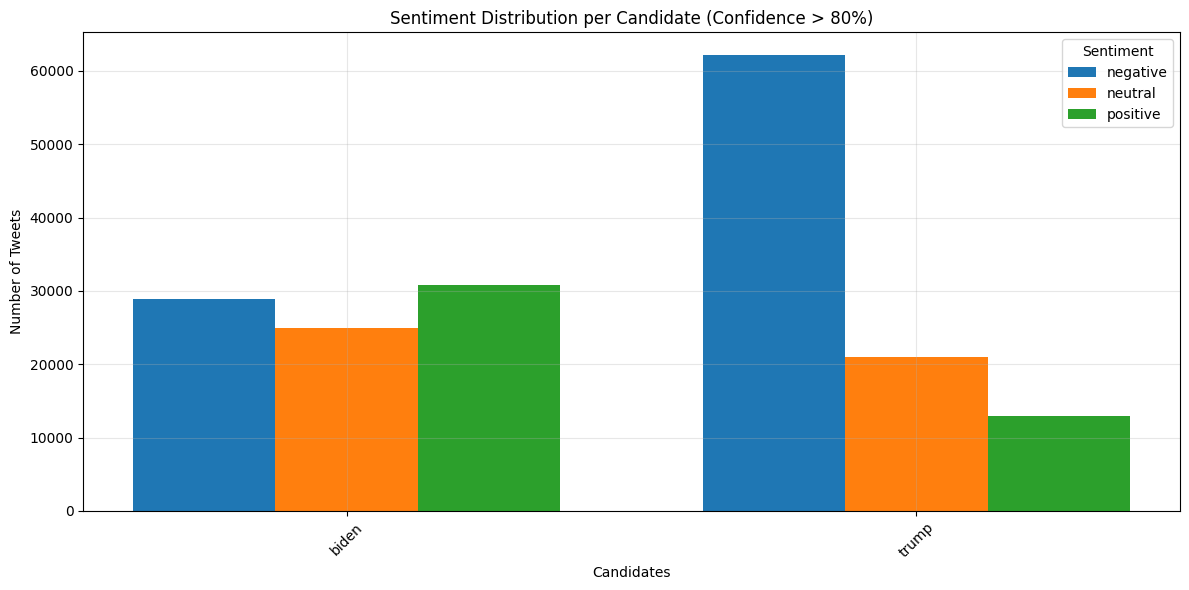

In [169]:
# Let's chart the data by tweet count
sentiment_counts = (tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > 0.80]
                   .groupby('candidate')['sentiment']
                   .value_counts()
                   .unstack(fill_value=0))

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_counts.index
sentiments = sentiment_counts.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_counts[sentiment], 
            bar_width, 
            label=sentiment)

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Distribution per Candidate (Confidence > 80%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

Let's look at the normalized distribution for confidence >80%.

In [170]:
# Sentiment distribution with confidence > 80%
print(
    tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > 0.80]
    .groupby('candidate')['sentiment']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

sentiment   negative    neutral   positive
candidate                                 
biden      34.178666  29.466933  36.354402
trump      64.685435  21.790082  13.524484


And the same for confidence >90%

In [ ]:
# Sentiment distribution with confidence > 90%
print(
    tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > 0.90]
    .groupby('candidate')['sentiment']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

sentiment   negative    neutral   positive
candidate                                 
biden      24.163057  12.846037  62.990906
trump      62.223835  13.271683  24.504482


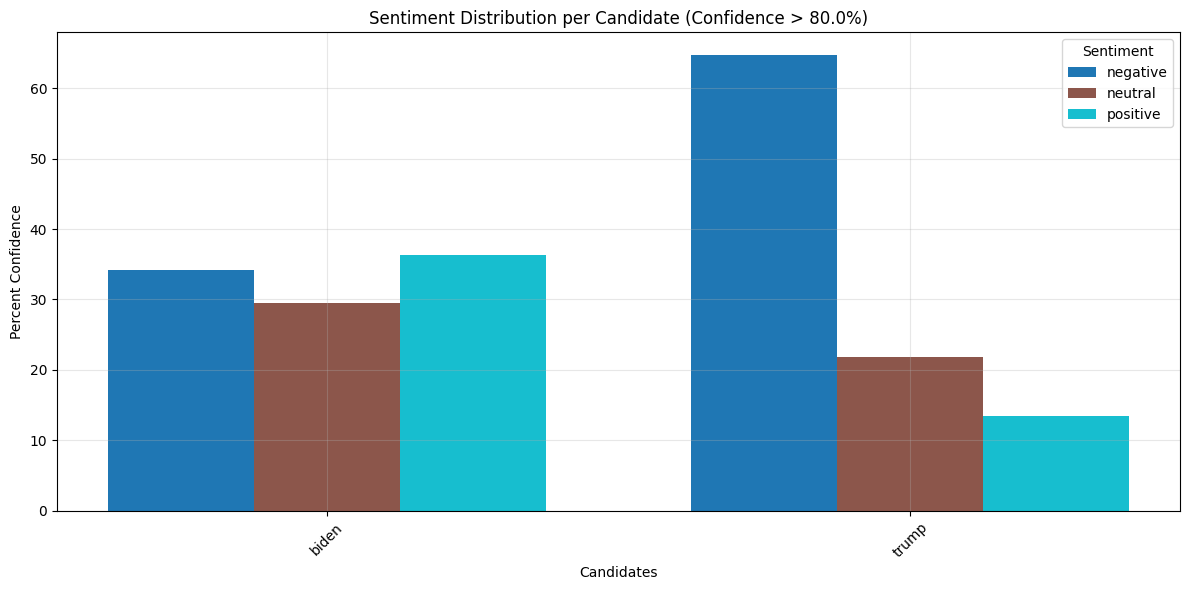

In [181]:
# Let's chart the distribution with confidence > 80%
confidence = 0.8
sentiment_dist = (tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > confidence]
                  .groupby('candidate')['sentiment']
                  .value_counts(normalize=True)
                  .unstack(fill_value=0) * 100)

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_dist.index
sentiments = sentiment_dist.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Use a colormap
colors = plt.get_cmap('tab10', n_sentiments)  # 'tab10' gives distinct, high-contrast colors

# Plot bars for each sentiment with colormap colors
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_dist[sentiment], 
            bar_width, 
            label=sentiment,
            color=colors(i))  # Get color from colormap

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Percent Confidence')
plt.title(f'Sentiment Distribution per Candidate (Confidence > {confidence * 100}%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

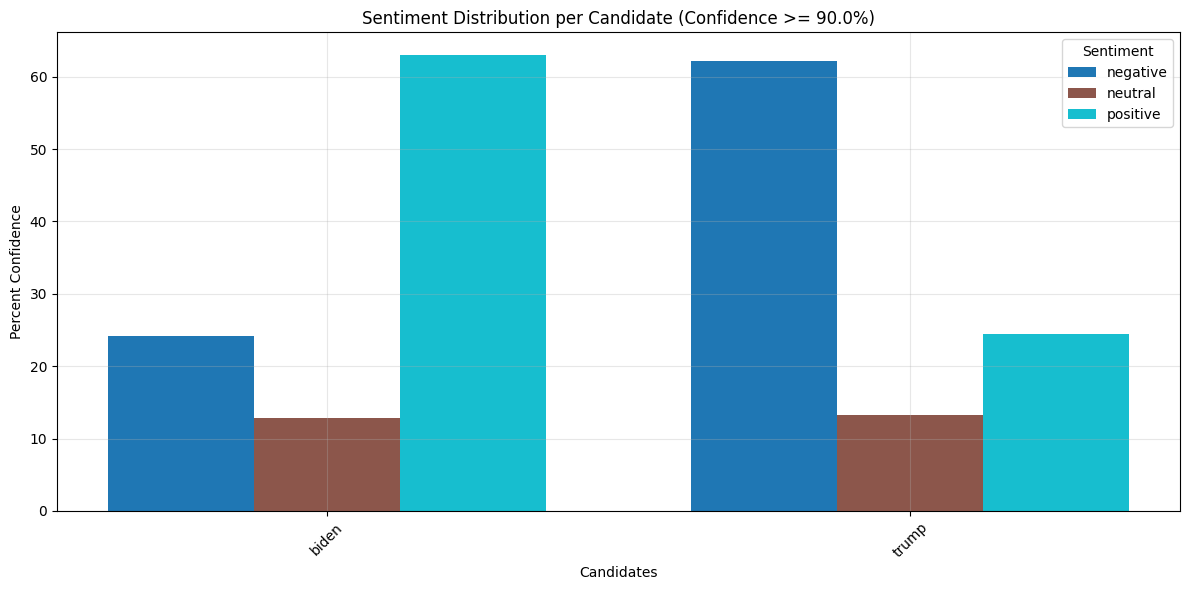

In [182]:
# Let's chart the distribution with confidence > 90%
confidence = 0.9
sentiment_dist = (tweetUSA_sentiments[tweetUSA_sentiments['sentiment_score'] > confidence]
                  .groupby('candidate')['sentiment']
                  .value_counts(normalize=True)
                  .unstack(fill_value=0) * 100)

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_dist.index
sentiments = sentiment_dist.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Use a colormap
colors = plt.get_cmap('tab10', n_sentiments)  # 'tab10' gives distinct, high-contrast colors

# Plot bars for each sentiment with colormap colors
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_dist[sentiment], 
            bar_width, 
            label=sentiment,
            color=colors(i))  # Get color from colormap

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Percent Confidence')
plt.title(f'Sentiment Distribution per Candidate (Confidence >= {confidence * 100}%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [152]:
print(
    tweetUSA_sentiments
    .groupby(['candidate', 'sentiment'])['sentiment_score']
    .describe()
    .unstack(fill_value=0)
)

              count                        mean                           std  \
sentiment  negative  neutral positive  negative   neutral  positive  negative   
candidate                                                                       
biden       68995.0  80680.0  51143.0  0.742165  0.701195  0.811217  0.137603   
trump      128988.0  78245.0  27468.0  0.761421  0.683370  0.759276  0.134136   

                                    min  ...       25%       50%            \
sentiment   neutral  positive  negative  ...  positive  negative   neutral   
candidate                                ...                                 
biden      0.139367  0.162244  0.336065  ...  0.685270  0.766376  0.709392   
trump      0.141618  0.166314  0.337859  ...  0.617765  0.792752  0.679104   

                          75%                           max            \
sentiment  positive  negative   neutral  positive  negative   neutral   
candidate                                                

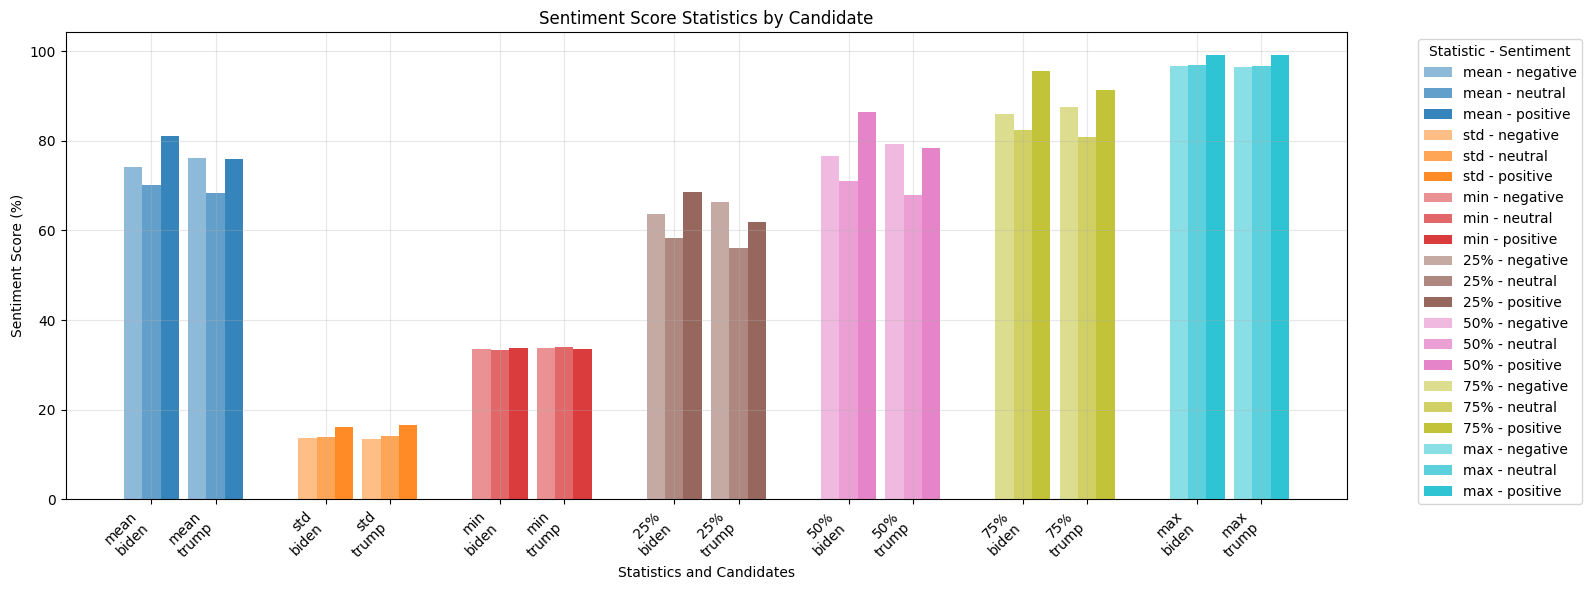

In [214]:
# Sentiment stats
sentiment_info = (tweetUSA_sentiments
                 .groupby(['candidate', 'sentiment'])['sentiment_score']
                 .describe()
                 .unstack(fill_value=0) * 100)

# Drop 'count' in place
sentiment_info.drop('count', level=0, axis=1, inplace=True)

# Get candidates, sentiments, and stats
candidates = sentiment_info.index
sentiments = sentiment_info.columns.levels[1]  # negative, neutral, positive
stats_types = [col for col in sentiment_info.columns.levels[0] if col != 'count']  # Exclude 'count'
n_sentiments = len(sentiments)
n_stats = len(stats_types)
n_candidates = len(candidates)
bar_width = 0.2
candidate_gap = 0.1  # Small gap between candidates within a stat
stat_gap = 0.5  # Larger gap between statistic groups

# Create the plot
plt.figure(figsize=(16, 6))

# Use colormaps: one for stats
stat_colors = plt.get_cmap('tab10', n_stats)

# Plot bars for each statistic, candidate, and sentiment
for stat_idx, stat in enumerate(stats_types):
    stat_base = stat_idx * (n_candidates * n_sentiments * bar_width + n_candidates * candidate_gap + stat_gap)
    for cand_idx, candidate in enumerate(candidates):
        cand_base = stat_base + cand_idx * (n_sentiments * bar_width + candidate_gap)
        for i, sentiment in enumerate(sentiments):
            pos = cand_base + i * bar_width
            column_key = (stat, sentiment)
            # Label all sentiments for the first candidate per stat
            if cand_idx == 0:
                label = f'{stat} - {sentiment}'
            else:
                label = None
            plt.bar(pos,
                    sentiment_info.loc[candidate, column_key],
                    bar_width,
                    label=label,
                    color=stat_colors(stat_idx),
                    alpha=0.5 + i * 0.2)

# Customize the plot
plt.xlabel('Statistics and Candidates')
plt.ylabel('Sentiment Score (%)')
plt.title('Sentiment Score Statistics by Candidate')

# Create custom x-ticks centered under each candidate’s triplet
tick_positions = []
tick_labels = []
for stat_idx, stat in enumerate(stats_types):
    stat_base = stat_idx * (n_candidates * n_sentiments * bar_width + n_candidates * candidate_gap + stat_gap)
    for cand_idx, candidate in enumerate(candidates):
        cand_base = stat_base + cand_idx * (n_sentiments * bar_width + candidate_gap)
        tick_pos = cand_base + (n_sentiments * bar_width) / 2 - bar_width / 2  # Center under triplet
        tick_positions.append(tick_pos)
        tick_labels.append(f'{stat}\n{candidate}')

plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
plt.legend(title='Statistic - Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [147]:
# Mean confidence per sentiment
mean_confidence = tweetUSA_sentiments.\
                  groupby(['candidate', 'sentiment'])['sentiment_score'].\
                  mean().unstack(fill_value=0)
print(mean_confidence)

sentiment  negative   neutral  positive
candidate                              
biden      0.742165  0.701195  0.811217
trump      0.761421  0.683370  0.759276


---
#### Compare sentiment results against full tweet dataset which includes all locations in the data.

In [ ]:
# Convert the ALL tweets dataframe into Hugging Face Dataset
tweetALL_dataset = Dataset.from_pandas(tweets_df)

In [ ]:
# Identify all rows which generate more than the maximum 512 tokens
rowlist = []

for i in tqdm(range(len(tweetALL_dataset))):
    tweet_text = tweetALL_dataset[i]['tweet']
    tokens = tokenizer(tweet_text)['input_ids']
    if len(tokens) > 512:
        print(f"Tweet token length: {len(tokens)} at row {i}")
        rowlist.append(i)

  0%|          | 1281/1747805 [00:00<11:05, 2625.77it/s]

Tweet token length: 529 at row 993


  3%|▎         | 46543/1747805 [00:17<10:26, 2715.21it/s]

Tweet token length: 537 at row 46175


  5%|▍         | 80147/1747805 [00:30<11:27, 2427.27it/s]

Tweet token length: 524 at row 79721


  5%|▍         | 80878/1747805 [00:30<11:43, 2369.12it/s]

Tweet token length: 524 at row 80486


  5%|▍         | 84192/1747805 [00:32<10:55, 2538.63it/s]

Tweet token length: 562 at row 83867


  5%|▍         | 85781/1747805 [00:32<10:32, 2625.74it/s]

Tweet token length: 596 at row 85462


  6%|▌         | 102999/1747805 [00:39<10:36, 2586.13it/s]

Tweet token length: 570 at row 102563


  7%|▋         | 120840/1747805 [00:46<10:07, 2679.94it/s]

Tweet token length: 611 at row 120329


  7%|▋         | 122467/1747805 [00:46<10:17, 2631.92it/s]

Tweet token length: 717 at row 122043


  7%|▋         | 125881/1747805 [00:48<10:12, 2647.17it/s]

Tweet token length: 616 at row 125563


  8%|▊         | 140877/1747805 [00:53<09:45, 2744.59it/s]

Tweet token length: 562 at row 140638


  8%|▊         | 141706/1747805 [00:53<09:53, 2706.09it/s]

Tweet token length: 678 at row 141268


  8%|▊         | 145479/1747805 [00:55<10:00, 2668.19it/s]

Tweet token length: 623 at row 145130


  9%|▊         | 152521/1747805 [00:58<09:47, 2715.97it/s]

Tweet token length: 643 at row 152104


  9%|▉         | 163248/1747805 [01:01<08:40, 3044.77it/s]

Tweet token length: 568 at row 162930


 10%|█         | 177568/1747805 [01:07<08:56, 2925.39it/s]

Tweet token length: 671 at row 177315


 10%|█         | 179019/1747805 [01:07<09:54, 2637.60it/s]

Tweet token length: 550 at row 178622


 10%|█         | 179828/1747805 [01:07<10:05, 2587.68it/s]

Tweet token length: 518 at row 179630


 10%|█         | 180662/1747805 [01:08<09:48, 2661.24it/s]

Tweet token length: 557 at row 180141
Tweet token length: 526 at row 180185


 10%|█         | 183150/1747805 [01:09<09:43, 2682.03it/s]

Tweet token length: 615 at row 182897


 11%|█         | 185327/1747805 [01:09<09:40, 2690.53it/s]

Tweet token length: 686 at row 184847
Tweet token length: 583 at row 184889


 11%|█         | 186399/1747805 [01:10<10:02, 2591.50it/s]

Tweet token length: 535 at row 186077


 11%|█         | 196589/1747805 [01:14<09:40, 2670.44it/s]

Tweet token length: 627 at row 196305


 11%|█▏        | 200128/1747805 [01:15<09:27, 2725.11it/s]

Tweet token length: 580 at row 199702


 12%|█▏        | 213269/1747805 [01:20<10:22, 2465.19it/s]

Tweet token length: 525 at row 212907
Tweet token length: 524 at row 213132


 12%|█▏        | 216715/1747805 [01:21<09:28, 2691.69it/s]

Tweet token length: 533 at row 216388


 12%|█▏        | 217802/1747805 [01:22<09:34, 2660.99it/s]

Tweet token length: 649 at row 217469


 13%|█▎        | 229358/1747805 [01:26<09:13, 2742.28it/s]

Tweet token length: 585 at row 228971


 13%|█▎        | 230723/1747805 [01:26<09:30, 2658.17it/s]

Tweet token length: 643 at row 230398


 13%|█▎        | 233113/1747805 [01:27<09:34, 2637.07it/s]

Tweet token length: 539 at row 232589


 13%|█▎        | 233637/1747805 [01:28<09:44, 2590.53it/s]

Tweet token length: 532 at row 233411


 14%|█▍        | 249612/1747805 [01:34<09:07, 2735.82it/s]

Tweet token length: 665 at row 249230


 16%|█▌        | 273661/1747805 [01:42<09:35, 2560.12it/s]

Tweet token length: 569 at row 273271


 16%|█▋        | 288296/1747805 [01:48<08:45, 2776.76it/s]

Tweet token length: 794 at row 287940


 17%|█▋        | 302036/1747805 [01:53<09:05, 2651.53it/s]

Tweet token length: 675 at row 301533


 18%|█▊        | 320498/1747805 [02:00<08:44, 2720.12it/s]

Tweet token length: 571 at row 320097


 19%|█▊        | 323469/1747805 [02:01<08:50, 2682.47it/s]

Tweet token length: 543 at row 323235


 19%|█▊        | 326200/1747805 [02:02<08:42, 2722.72it/s]

Tweet token length: 533 at row 325754


 23%|██▎       | 393798/1747805 [02:27<08:27, 2666.15it/s]

Tweet token length: 560 at row 393363


 23%|██▎       | 399226/1747805 [02:29<08:47, 2557.90it/s]

Tweet token length: 524 at row 398741


 24%|██▍       | 418799/1747805 [02:36<07:53, 2804.17it/s]

Tweet token length: 526 at row 418478


 24%|██▍       | 421327/1747805 [02:37<08:00, 2761.76it/s]

Tweet token length: 577 at row 420832
Tweet token length: 617 at row 421240


 24%|██▍       | 425952/1747805 [02:39<08:11, 2687.24it/s]

Tweet token length: 593 at row 425440


 25%|██▍       | 430040/1747805 [02:40<08:00, 2740.47it/s]

Tweet token length: 526 at row 429561


 25%|██▍       | 430584/1747805 [02:41<08:15, 2659.25it/s]

Tweet token length: 557 at row 430218


 25%|██▍       | 433555/1747805 [02:42<08:15, 2654.51it/s]

Tweet token length: 538 at row 433034


 25%|██▍       | 433821/1747805 [02:42<08:26, 2592.65it/s]

Tweet token length: 527 at row 433572


 25%|██▌       | 437822/1747805 [02:43<08:14, 2650.94it/s]

Tweet token length: 660 at row 437535


 27%|██▋       | 470874/1747805 [02:55<07:43, 2753.33it/s]

Tweet token length: 578 at row 470393


 27%|██▋       | 476348/1747805 [02:57<08:49, 2401.53it/s]

Tweet token length: 588 at row 476200


 27%|██▋       | 480107/1747805 [02:59<08:52, 2382.08it/s]

Tweet token length: 758 at row 479884


 28%|██▊       | 486289/1747805 [03:02<08:23, 2506.06it/s]

Tweet token length: 574 at row 485838


 28%|██▊       | 488434/1747805 [03:03<08:53, 2361.57it/s]

Tweet token length: 597 at row 488127


 28%|██▊       | 490548/1747805 [03:04<07:56, 2636.93it/s]

Tweet token length: 601 at row 490178


 28%|██▊       | 491629/1747805 [03:04<07:46, 2690.98it/s]

Tweet token length: 620 at row 491147


 28%|██▊       | 492443/1747805 [03:04<07:48, 2682.32it/s]

Tweet token length: 531 at row 491986


 28%|██▊       | 494104/1747805 [03:05<08:17, 2519.51it/s]

Tweet token length: 573 at row 493762


 29%|██▊       | 500699/1747805 [03:08<07:32, 2756.06it/s]

Tweet token length: 636 at row 500253


 29%|██▉       | 504293/1747805 [03:09<07:26, 2784.64it/s]

Tweet token length: 579 at row 503808


 30%|██▉       | 516928/1747805 [03:13<07:45, 2642.58it/s]

Tweet token length: 679 at row 516683
Tweet token length: 576 at row 516751


 30%|██▉       | 520579/1747805 [03:15<07:15, 2816.89it/s]

Tweet token length: 556 at row 520083


 30%|███       | 527706/1747805 [03:17<07:02, 2888.61it/s]

Tweet token length: 632 at row 527200


 31%|███       | 533229/1747805 [03:19<06:58, 2902.54it/s]

Tweet token length: 626 at row 532893


 31%|███       | 534400/1747805 [03:20<07:01, 2876.61it/s]

Tweet token length: 523 at row 534022


 31%|███       | 543095/1747805 [03:23<06:56, 2893.98it/s]

Tweet token length: 704 at row 542741


 31%|███▏      | 549406/1747805 [03:25<07:01, 2844.40it/s]

Tweet token length: 548 at row 548857
Tweet token length: 567 at row 549149


 32%|███▏      | 551349/1747805 [03:26<07:23, 2697.35it/s]

Tweet token length: 519 at row 551041


 32%|███▏      | 559898/1747805 [03:29<06:58, 2836.85it/s]

Tweet token length: 550 at row 559586


 32%|███▏      | 561602/1747805 [03:29<07:09, 2760.93it/s]

Tweet token length: 667 at row 561254


 32%|███▏      | 564341/1747805 [03:30<08:21, 2357.72it/s]

Tweet token length: 551 at row 564029


 33%|███▎      | 571981/1747805 [03:33<06:45, 2901.66it/s]

Tweet token length: 626 at row 571526


 33%|███▎      | 572834/1747805 [03:33<07:10, 2729.34it/s]

Tweet token length: 609 at row 572416


 33%|███▎      | 573902/1747805 [03:34<07:29, 2611.18it/s]

Tweet token length: 513 at row 573534


 33%|███▎      | 575530/1747805 [03:35<07:15, 2692.82it/s]

Tweet token length: 586 at row 575060
Tweet token length: 595 at row 575363
Tweet token length: 590 at row 575478


 33%|███▎      | 576068/1747805 [03:35<07:49, 2496.39it/s]

Tweet token length: 513 at row 575752


 33%|███▎      | 578260/1747805 [03:36<07:14, 2691.90it/s]

Tweet token length: 669 at row 577980


 33%|███▎      | 579892/1747805 [03:36<07:16, 2676.50it/s]

Tweet token length: 516 at row 579543


 34%|███▍      | 592906/1747805 [03:41<07:09, 2689.67it/s]

Tweet token length: 521 at row 592510
Tweet token length: 571 at row 592625


 34%|███▍      | 593714/1747805 [03:41<07:14, 2653.83it/s]

Tweet token length: 618 at row 593325


 34%|███▍      | 601590/1747805 [03:44<06:59, 2729.63it/s]

Tweet token length: 615 at row 601307


 34%|███▍      | 602681/1747805 [03:45<07:09, 2663.90it/s]

Tweet token length: 625 at row 602424


 35%|███▍      | 603756/1747805 [03:45<07:20, 2597.91it/s]

Tweet token length: 584 at row 603456


 35%|███▍      | 610060/1747805 [03:47<06:56, 2731.89it/s]

Tweet token length: 683 at row 609757


 36%|███▌      | 621675/1747805 [03:52<07:01, 2674.16it/s]

Tweet token length: 734 at row 621459


 37%|███▋      | 641257/1747805 [03:59<06:32, 2819.94it/s]

Tweet token length: 620 at row 640897
Tweet token length: 611 at row 640898


 37%|███▋      | 654586/1747805 [04:04<06:33, 2774.84it/s]

Tweet token length: 600 at row 654330


 38%|███▊      | 656862/1747805 [04:05<06:25, 2830.09it/s]

Tweet token length: 621 at row 656491
Tweet token length: 517 at row 656492
Tweet token length: 519 at row 657088


 38%|███▊      | 659088/1747805 [04:05<06:39, 2727.20it/s]

Tweet token length: 540 at row 658787


 38%|███▊      | 662714/1747805 [04:07<06:33, 2760.21it/s]

Tweet token length: 587 at row 662208
Tweet token length: 552 at row 662294


 38%|███▊      | 663265/1747805 [04:07<06:38, 2722.04it/s]

Tweet token length: 550 at row 662936


 38%|███▊      | 667683/1747805 [04:09<06:43, 2678.94it/s]

Tweet token length: 714 at row 667210


 38%|███▊      | 668501/1747805 [04:09<06:44, 2666.30it/s]

Tweet token length: 655 at row 668052


 38%|███▊      | 669034/1747805 [04:09<06:48, 2640.12it/s]

Tweet token length: 688 at row 668790


 38%|███▊      | 670114/1747805 [04:09<06:41, 2682.97it/s]

Tweet token length: 647 at row 669588


 39%|███▊      | 675290/1747805 [04:11<06:40, 2677.60it/s]

Tweet token length: 616 at row 675062


 39%|███▉      | 678528/1747805 [04:13<06:36, 2695.99it/s]

Tweet token length: 657 at row 678105


 39%|███▉      | 679874/1747805 [04:13<06:58, 2554.60it/s]

Tweet token length: 615 at row 679432


 39%|███▉      | 681477/1747805 [04:14<06:39, 2667.99it/s]

Tweet token length: 688 at row 681125


 39%|███▉      | 687233/1747805 [04:16<06:30, 2715.07it/s]

Tweet token length: 542 at row 686770
Tweet token length: 527 at row 686942


 40%|███▉      | 694473/1747805 [04:19<06:24, 2740.80it/s]

Tweet token length: 678 at row 694131


 40%|███▉      | 698386/1747805 [04:20<06:17, 2776.29it/s]

Tweet token length: 582 at row 697886


 41%|████      | 712761/1747805 [04:25<06:07, 2813.24it/s]

Tweet token length: 684 at row 712443


 42%|████▏     | 732870/1747805 [04:32<06:01, 2809.35it/s]

Tweet token length: 630 at row 732360


 42%|████▏     | 736020/1747805 [04:33<05:55, 2843.81it/s]

Tweet token length: 518 at row 735502
Tweet token length: 532 at row 735557


 42%|████▏     | 741106/1747805 [04:35<06:00, 2794.05it/s]

Tweet token length: 584 at row 740722


 42%|████▏     | 742503/1747805 [04:36<06:05, 2747.27it/s]

Tweet token length: 594 at row 742075


 43%|████▎     | 746163/1747805 [04:37<05:56, 2812.72it/s]

Tweet token length: 642 at row 745663


 43%|████▎     | 747829/1747805 [04:38<06:04, 2740.53it/s]

Tweet token length: 646 at row 747365


 43%|████▎     | 748644/1747805 [04:38<06:37, 2512.91it/s]

Tweet token length: 616 at row 748372


 43%|████▎     | 751646/1747805 [04:39<06:06, 2717.38it/s]

Tweet token length: 658 at row 751289


 43%|████▎     | 756068/1747805 [04:41<06:07, 2695.46it/s]

Tweet token length: 550 at row 755770


 44%|████▎     | 761041/1747805 [04:42<05:58, 2755.87it/s]

Tweet token length: 667 at row 760862


 44%|████▍     | 768699/1747805 [04:45<06:02, 2701.50it/s]

Tweet token length: 648 at row 768307


 44%|████▍     | 772006/1747805 [04:47<05:51, 2773.20it/s]

Tweet token length: 622 at row 771621


 44%|████▍     | 773388/1747805 [04:47<05:58, 2720.77it/s]

Tweet token length: 633 at row 773062


 45%|████▍     | 778696/1747805 [04:49<05:46, 2796.79it/s]

Tweet token length: 667 at row 778272


 45%|████▍     | 779535/1747805 [04:49<05:56, 2712.47it/s]

Tweet token length: 667 at row 779245


 45%|████▍     | 782327/1747805 [04:50<05:48, 2773.73it/s]

Tweet token length: 666 at row 781946


 45%|████▍     | 785107/1747805 [04:51<05:51, 2742.21it/s]

Tweet token length: 601 at row 784577


 45%|████▌     | 787028/1747805 [04:52<05:53, 2717.84it/s]

Tweet token length: 588 at row 786541


 47%|████▋     | 813994/1747805 [05:02<05:31, 2816.09it/s]

Tweet token length: 525 at row 813531
Tweet token length: 656 at row 813771


 47%|████▋     | 814814/1747805 [05:02<05:50, 2659.36it/s]

Tweet token length: 531 at row 814518


 47%|████▋     | 816454/1747805 [05:03<05:50, 2653.98it/s]

Tweet token length: 532 at row 816172


 47%|████▋     | 817541/1747805 [05:03<06:07, 2529.77it/s]

Tweet token length: 701 at row 817010


 47%|████▋     | 818351/1747805 [05:03<05:50, 2651.95it/s]

Tweet token length: 669 at row 818066


 47%|████▋     | 819456/1747805 [05:04<05:42, 2710.43it/s]

Tweet token length: 587 at row 818967


 47%|████▋     | 825201/1747805 [05:06<05:51, 2628.06it/s]

Tweet token length: 593 at row 824933


 47%|████▋     | 827050/1747805 [05:07<05:51, 2618.59it/s]

Tweet token length: 658 at row 826769


 48%|████▊     | 831937/1747805 [05:09<05:37, 2712.30it/s]

Tweet token length: 519 at row 831528


 48%|████▊     | 832751/1747805 [05:09<05:40, 2685.79it/s]

Tweet token length: 530 at row 832498


 49%|████▉     | 861120/1747805 [05:19<05:10, 2853.97it/s]

Tweet token length: 517 at row 860728


 49%|████▉     | 861975/1747805 [05:19<05:43, 2577.82it/s]

Tweet token length: 550 at row 861638


 49%|████▉     | 863107/1747805 [05:20<05:18, 2779.82it/s]

Tweet token length: 612 at row 862580


 50%|████▉     | 865326/1747805 [05:20<05:20, 2752.76it/s]

Tweet token length: 652 at row 864804


 50%|█████     | 875223/1747805 [05:24<05:19, 2731.55it/s]

Tweet token length: 653 at row 874677
Tweet token length: 520 at row 874953


 50%|█████     | 878387/1747805 [05:25<05:00, 2894.52it/s]

Tweet token length: 544 at row 877827


 50%|█████     | 878961/1747805 [05:25<05:13, 2775.12it/s]

Tweet token length: 520 at row 878507


 51%|█████     | 889861/1747805 [05:29<05:08, 2784.13it/s]

Tweet token length: 580 at row 889538


 51%|█████     | 891836/1747805 [05:30<05:06, 2791.10it/s]

Tweet token length: 642 at row 891505


 52%|█████▏    | 904488/1747805 [05:34<04:55, 2849.10it/s]

Tweet token length: 604 at row 903983


 52%|█████▏    | 914792/1747805 [05:38<04:54, 2830.58it/s]

Tweet token length: 536 at row 914363


 52%|█████▏    | 916447/1747805 [05:39<05:07, 2700.42it/s]

Tweet token length: 530 at row 916149


 53%|█████▎    | 918069/1747805 [05:39<05:14, 2636.16it/s]

Tweet token length: 653 at row 917716


 53%|█████▎    | 919135/1747805 [05:40<05:26, 2535.23it/s]

Tweet token length: 572 at row 918617


 53%|█████▎    | 920230/1747805 [05:40<05:07, 2692.28it/s]

Tweet token length: 625 at row 919905


 54%|█████▎    | 938937/1747805 [05:47<04:53, 2757.97it/s]

Tweet token length: 673 at row 938500


 54%|█████▍    | 941393/1747805 [05:48<04:55, 2730.08it/s]

Tweet token length: 645 at row 941108


 55%|█████▍    | 956997/1747805 [05:54<04:46, 2757.57it/s]

Tweet token length: 615 at row 956498


 56%|█████▌    | 970875/1747805 [05:59<04:39, 2780.45it/s]

Tweet token length: 696 at row 970371


 56%|█████▌    | 975961/1747805 [06:01<04:50, 2661.32it/s]

Tweet token length: 520 at row 975502


 58%|█████▊    | 1010569/1747805 [06:14<04:24, 2783.24it/s]

Tweet token length: 572 at row 1010147


 59%|█████▉    | 1027580/1747805 [06:20<04:15, 2819.82it/s]

Tweet token length: 524 at row 1027262
Tweet token length: 524 at row 1027672


 60%|██████    | 1050616/1747805 [06:29<04:22, 2653.00it/s]

Tweet token length: 555 at row 1050316


 60%|██████    | 1056181/1747805 [06:31<04:23, 2629.32it/s]

Tweet token length: 564 at row 1055895


 62%|██████▏   | 1088951/1747805 [06:43<03:28, 3155.56it/s]

Tweet token length: 698 at row 1088605


 62%|██████▏   | 1089891/1747805 [06:43<03:32, 3093.57it/s]

Tweet token length: 596 at row 1089546


 62%|██████▏   | 1091104/1747805 [06:43<03:44, 2925.35it/s]

Tweet token length: 578 at row 1090706


 63%|██████▎   | 1095401/1747805 [06:45<03:34, 3042.86it/s]

Tweet token length: 618 at row 1095020


 63%|██████▎   | 1096950/1747805 [06:45<03:39, 2971.20it/s]

Tweet token length: 671 at row 1096769


 63%|██████▎   | 1100252/1747805 [06:47<03:36, 2996.19it/s]

Tweet token length: 518 at row 1099840
Tweet token length: 557 at row 1100453


 63%|██████▎   | 1100851/1747805 [06:47<03:37, 2968.89it/s]

Tweet token length: 526 at row 1100500


 66%|██████▋   | 1162076/1747805 [07:08<03:30, 2784.41it/s]

Tweet token length: 545 at row 1161664


 69%|██████▉   | 1202017/1747805 [07:23<03:15, 2798.45it/s]

Tweet token length: 642 at row 1201530


 71%|███████▏  | 1248368/1747805 [07:40<02:58, 2802.11it/s]

Tweet token length: 524 at row 1247955


 72%|███████▏  | 1265667/1747805 [07:46<02:59, 2680.53it/s]

Tweet token length: 526 at row 1265325
Tweet token length: 557 at row 1265680


 73%|███████▎  | 1270691/1747805 [07:48<02:48, 2827.40it/s]

Tweet token length: 660 at row 1270184


 74%|███████▍  | 1298761/1747805 [07:58<02:50, 2637.97it/s]

Tweet token length: 574 at row 1298514


 74%|███████▍  | 1300421/1747805 [07:59<02:43, 2741.80it/s]

Tweet token length: 645 at row 1299889


 75%|███████▍  | 1302363/1747805 [07:59<02:44, 2712.30it/s]

Tweet token length: 620 at row 1301912


 75%|███████▍  | 1302904/1747805 [07:59<02:50, 2607.32it/s]

Tweet token length: 531 at row 1302533


 75%|███████▌  | 1318602/1747805 [08:05<02:38, 2699.73it/s]

Tweet token length: 679 at row 1318153
Tweet token length: 576 at row 1318190


 76%|███████▌  | 1325693/1747805 [08:08<02:25, 2891.83it/s]

Tweet token length: 654 at row 1325298


 76%|███████▌  | 1330634/1747805 [08:10<02:25, 2869.38it/s]

Tweet token length: 523 at row 1330141


 76%|███████▋  | 1335015/1747805 [08:11<02:24, 2860.49it/s]

Tweet token length: 637 at row 1334781
Tweet token length: 622 at row 1335237


 77%|███████▋  | 1337281/1747805 [08:12<02:25, 2815.76it/s]

Tweet token length: 704 at row 1336860


 77%|███████▋  | 1341137/1747805 [08:13<02:31, 2688.73it/s]

Tweet token length: 548 at row 1340813


 77%|███████▋  | 1342828/1747805 [08:14<02:26, 2763.04it/s]

Tweet token length: 519 at row 1342505


 77%|███████▋  | 1344216/1747805 [08:14<02:29, 2695.08it/s]

Tweet token length: 627 at row 1343920


 77%|███████▋  | 1345054/1747805 [08:15<02:26, 2745.81it/s]

Tweet token length: 574 at row 1344612


 77%|███████▋  | 1346170/1747805 [08:15<02:26, 2745.59it/s]

Tweet token length: 574 at row 1345659


 77%|███████▋  | 1349994/1747805 [08:16<02:24, 2761.42it/s]

Tweet token length: 550 at row 1349696


 77%|███████▋  | 1353077/1747805 [08:18<02:21, 2786.11it/s]

Tweet token length: 619 at row 1352606
Tweet token length: 551 at row 1353080


 78%|███████▊  | 1358071/1747805 [08:19<02:22, 2733.26it/s]

Tweet token length: 524 at row 1357605
Tweet token length: 513 at row 1357673


 78%|███████▊  | 1358612/1747805 [08:20<02:26, 2650.82it/s]

Tweet token length: 595 at row 1358328
Tweet token length: 590 at row 1358367
Tweet token length: 513 at row 1358479


 78%|███████▊  | 1359957/1747805 [08:20<02:40, 2420.41it/s]

Tweet token length: 669 at row 1359549


 78%|███████▊  | 1360742/1747805 [08:21<02:32, 2538.08it/s]

Tweet token length: 516 at row 1360409
Tweet token length: 577 at row 1360700


 78%|███████▊  | 1361819/1747805 [08:21<02:25, 2659.30it/s]

Tweet token length: 552 at row 1361281


 78%|███████▊  | 1366198/1747805 [08:23<02:17, 2766.30it/s]

Tweet token length: 623 at row 1365755


 78%|███████▊  | 1368105/1747805 [08:23<02:21, 2686.69it/s]

Tweet token length: 600 at row 1367672


 78%|███████▊  | 1369450/1747805 [08:24<02:25, 2609.05it/s]

Tweet token length: 521 at row 1369145
Tweet token length: 618 at row 1369713


 79%|███████▊  | 1375752/1747805 [08:26<02:15, 2737.01it/s]

Tweet token length: 615 at row 1375282


 81%|████████▏ | 1424075/1747805 [08:43<01:56, 2781.17it/s]

Tweet token length: 600 at row 1423631


 82%|████████▏ | 1425215/1747805 [08:44<01:53, 2841.98it/s]

Tweet token length: 651 at row 1424707


 82%|████████▏ | 1425779/1747805 [08:44<01:58, 2710.82it/s]

Tweet token length: 517 at row 1425455
Tweet token length: 621 at row 1425456
Tweet token length: 519 at row 1425913


 82%|████████▏ | 1428023/1747805 [08:45<01:53, 2809.35it/s]

Tweet token length: 540 at row 1427556


 82%|████████▏ | 1430525/1747805 [08:46<01:54, 2776.33it/s]

Tweet token length: 577 at row 1429995


 82%|████████▏ | 1431084/1747805 [08:46<02:04, 2535.70it/s]

Tweet token length: 587 at row 1430779


 82%|████████▏ | 1431914/1747805 [08:46<01:57, 2684.08it/s]

Tweet token length: 550 at row 1431540


 82%|████████▏ | 1433018/1747805 [08:47<01:57, 2671.57it/s]

Tweet token length: 753 at row 1432705
Tweet token length: 552 at row 1432814


 82%|████████▏ | 1435481/1747805 [08:48<01:56, 2679.95it/s]

Tweet token length: 714 at row 1435172
Tweet token length: 655 at row 1435700


 82%|████████▏ | 1436028/1747805 [08:48<01:58, 2620.66it/s]

Tweet token length: 649 at row 1435788
Tweet token length: 634 at row 1436032


 82%|████████▏ | 1437098/1747805 [08:48<01:58, 2631.35it/s]

Tweet token length: 647 at row 1436675


 82%|████████▏ | 1439184/1747805 [08:49<02:07, 2426.92it/s]

Tweet token length: 578 at row 1438909


 82%|████████▏ | 1440769/1747805 [08:50<01:58, 2583.48it/s]

Tweet token length: 616 at row 1440450


 83%|████████▎ | 1442934/1747805 [08:51<01:54, 2659.71it/s]

Tweet token length: 668 at row 1442468
Tweet token length: 657 at row 1442599


 83%|████████▎ | 1444279/1747805 [08:51<01:54, 2639.88it/s]

Tweet token length: 532 at row 1443967
Tweet token length: 583 at row 1444316


 83%|████████▎ | 1445081/1747805 [08:51<01:55, 2630.30it/s]

Tweet token length: 570 at row 1444586
Tweet token length: 688 at row 1444706
Tweet token length: 534 at row 1444789


 83%|████████▎ | 1448850/1747805 [08:53<01:54, 2621.59it/s]

Tweet token length: 527 at row 1448424


 83%|████████▎ | 1453468/1747805 [08:55<01:51, 2631.79it/s]

Tweet token length: 603 at row 1453248


 83%|████████▎ | 1455093/1747805 [08:55<01:49, 2663.50it/s]

Tweet token length: 567 at row 1454724


 83%|████████▎ | 1455890/1747805 [08:56<01:50, 2637.64it/s]

Tweet token length: 582 at row 1455429


 84%|████████▍ | 1469570/1747805 [09:01<01:39, 2787.59it/s]

Tweet token length: 648 at row 1469041


 84%|████████▍ | 1474047/1747805 [09:02<01:38, 2787.01it/s]

Tweet token length: 532 at row 1473493


 84%|████████▍ | 1474326/1747805 [09:02<01:49, 2488.45it/s]

Tweet token length: 659 at row 1474170


 84%|████████▍ | 1476526/1747805 [09:03<01:37, 2768.90it/s]

Tweet token length: 584 at row 1476055


 85%|████████▍ | 1478747/1747805 [09:04<01:37, 2753.10it/s]

Tweet token length: 565 at row 1478474


 85%|████████▍ | 1479846/1747805 [09:04<01:41, 2652.84it/s]

Tweet token length: 646 at row 1479515


 85%|████████▍ | 1484433/1747805 [09:06<01:50, 2389.47it/s]

Tweet token length: 598 at row 1484201


 85%|████████▌ | 1485791/1747805 [09:07<01:37, 2680.19it/s]

Tweet token length: 554 at row 1485316
Tweet token length: 646 at row 1485443


 85%|████████▌ | 1492288/1747805 [09:09<01:33, 2736.32it/s]

Tweet token length: 648 at row 1492040


 85%|████████▌ | 1493913/1747805 [09:10<01:35, 2661.32it/s]

Tweet token length: 622 at row 1493567


 86%|████████▌ | 1494722/1747805 [09:10<01:35, 2643.29it/s]

Tweet token length: 633 at row 1494219
Tweet token length: 622 at row 1494294


 86%|████████▌ | 1495292/1747805 [09:10<01:38, 2562.74it/s]

Tweet token length: 605 at row 1494843


 86%|████████▌ | 1500561/1747805 [09:12<01:25, 2896.32it/s]

Tweet token length: 667 at row 1500199


 86%|████████▌ | 1501429/1747805 [09:12<01:28, 2773.08it/s]

Tweet token length: 595 at row 1500978


 86%|████████▌ | 1503951/1747805 [09:13<01:28, 2762.43it/s]

Tweet token length: 769 at row 1503628
Tweet token length: 666 at row 1503726


 86%|████████▋ | 1509014/1747805 [09:15<01:24, 2833.61it/s]

Tweet token length: 557 at row 1508772


 87%|████████▋ | 1523181/1747805 [09:20<01:23, 2687.57it/s]

Tweet token length: 523 at row 1522881


 87%|████████▋ | 1524517/1747805 [09:21<01:25, 2600.98it/s]

Tweet token length: 565 at row 1524040
Tweet token length: 525 at row 1524058
Tweet token length: 656 at row 1524206


 87%|████████▋ | 1525052/1747805 [09:21<01:24, 2631.31it/s]

Tweet token length: 531 at row 1524640


 87%|████████▋ | 1525585/1747805 [09:21<01:24, 2640.85it/s]

Tweet token length: 593 at row 1525282


 87%|████████▋ | 1529137/1747805 [09:22<01:16, 2848.86it/s]

Tweet token length: 669 at row 1528692
Tweet token length: 534 at row 1528993


 88%|████████▊ | 1529699/1747805 [09:23<01:20, 2714.10it/s]

Tweet token length: 587 at row 1529452


 88%|████████▊ | 1531880/1747805 [09:23<01:20, 2698.16it/s]

Tweet token length: 594 at row 1531646
Tweet token length: 564 at row 1532119


 88%|████████▊ | 1534022/1747805 [09:24<01:20, 2664.12it/s]

Tweet token length: 593 at row 1533635


 88%|████████▊ | 1535339/1747805 [09:25<01:23, 2550.39it/s]

Tweet token length: 658 at row 1534990


 88%|████████▊ | 1538282/1747805 [09:26<01:18, 2658.34it/s]

Tweet token length: 519 at row 1537966


 89%|████████▉ | 1551651/1747805 [09:30<01:01, 3181.89it/s]

Tweet token length: 606 at row 1551118


 89%|████████▉ | 1554156/1747805 [09:31<01:02, 3082.40it/s]

Tweet token length: 689 at row 1553699


 89%|████████▉ | 1557928/1747805 [09:32<01:00, 3118.80it/s]

Tweet token length: 557 at row 1557395


 90%|████████▉ | 1564414/1747805 [09:35<01:00, 3045.57it/s]

Tweet token length: 568 at row 1563927


 90%|████████▉ | 1568072/1747805 [09:36<00:59, 2997.75it/s]

Tweet token length: 560 at row 1567656
Tweet token length: 642 at row 1567755


 90%|████████▉ | 1570166/1747805 [09:37<01:00, 2948.59it/s]

Tweet token length: 609 at row 1569921


 90%|████████▉ | 1571371/1747805 [09:37<01:00, 2896.94it/s]

Tweet token length: 624 at row 1571110


 90%|█████████ | 1575559/1747805 [09:38<00:57, 2995.35it/s]

Tweet token length: 611 at row 1575152


 91%|█████████ | 1585434/1747805 [09:42<00:55, 2936.99it/s]

Tweet token length: 710 at row 1585036


 91%|█████████ | 1586599/1747805 [09:42<00:56, 2829.31it/s]

Tweet token length: 777 at row 1586195


 91%|█████████ | 1591900/1747805 [09:44<00:56, 2755.69it/s]

Tweet token length: 583 at row 1591428


 91%|█████████ | 1594224/1747805 [09:45<00:53, 2878.11it/s]

Tweet token length: 517 at row 1593646


 91%|█████████▏| 1595985/1747805 [09:45<00:52, 2911.59it/s]

Tweet token length: 550 at row 1595485


 91%|█████████▏| 1597737/1747805 [09:46<00:51, 2905.85it/s]

Tweet token length: 612 at row 1597356


 92%|█████████▏| 1601924/1747805 [09:48<00:49, 2972.24it/s]

Tweet token length: 652 at row 1601454


 92%|█████████▏| 1602520/1747805 [09:48<00:52, 2755.22it/s]

Tweet token length: 565 at row 1602255
Tweet token length: 552 at row 1602459


 92%|█████████▏| 1606658/1747805 [09:49<00:48, 2935.15it/s]

Tweet token length: 701 at row 1606334


 92%|█████████▏| 1609042/1747805 [09:50<00:47, 2930.89it/s]

Tweet token length: 599 at row 1608460


 92%|█████████▏| 1615212/1747805 [09:52<00:45, 2890.63it/s]

Tweet token length: 528 at row 1614934


 92%|█████████▏| 1616101/1747805 [09:52<00:44, 2929.93it/s]

Tweet token length: 551 at row 1615604


 93%|█████████▎| 1619352/1747805 [09:54<00:44, 2918.61it/s]

Tweet token length: 717 at row 1618865
Tweet token length: 583 at row 1619357


 93%|█████████▎| 1619938/1747805 [09:54<00:43, 2908.13it/s]

Tweet token length: 653 at row 1619520
Tweet token length: 729 at row 1619596
Tweet token length: 520 at row 1620037


 93%|█████████▎| 1621107/1747805 [09:54<00:43, 2890.32it/s]

Tweet token length: 609 at row 1620593


 93%|█████████▎| 1622302/1747805 [09:55<00:42, 2951.89it/s]

Tweet token length: 701 at row 1621838
Tweet token length: 571 at row 1622063


 93%|█████████▎| 1625828/1747805 [09:56<00:41, 2913.08it/s]

Tweet token length: 544 at row 1625493


 93%|█████████▎| 1629913/1747805 [09:57<00:41, 2864.35it/s]

Tweet token length: 521 at row 1629441


 93%|█████████▎| 1633687/1747805 [09:58<00:39, 2894.32it/s]

Tweet token length: 638 at row 1633157


 94%|█████████▎| 1634857/1747805 [09:59<00:39, 2879.56it/s]

Tweet token length: 687 at row 1634350


 94%|█████████▍| 1638624/1747805 [10:00<00:38, 2854.80it/s]

Tweet token length: 558 at row 1638342
Tweet token length: 579 at row 1638586


 95%|█████████▌| 1662752/1747805 [10:09<00:29, 2868.27it/s]

Tweet token length: 604 at row 1662239


 96%|█████████▌| 1676049/1747805 [10:13<00:24, 2880.56it/s]

Tweet token length: 536 at row 1675646


 96%|█████████▌| 1677001/1747805 [10:14<00:22, 3083.05it/s]

Tweet token length: 552 at row 1676451


 96%|█████████▌| 1678864/1747805 [10:14<00:22, 3073.00it/s]

Tweet token length: 672 at row 1678407


 96%|█████████▌| 1681346/1747805 [10:15<00:22, 2993.15it/s]

Tweet token length: 521 at row 1680935


 96%|█████████▋| 1682501/1747805 [10:15<00:23, 2793.82it/s]

Tweet token length: 534 at row 1682091


 96%|█████████▋| 1684495/1747805 [10:16<00:22, 2766.24it/s]

Tweet token length: 565 at row 1684177
Tweet token length: 582 at row 1684298


 96%|█████████▋| 1685047/1747805 [10:16<00:22, 2739.77it/s]

Tweet token length: 582 at row 1684757
Tweet token length: 581 at row 1684903
Tweet token length: 600 at row 1685028
Tweet token length: 551 at row 1685072
Tweet token length: 580 at row 1685271
Tweet token length: 589 at row 1685311


 96%|█████████▋| 1685868/1747805 [10:17<00:22, 2702.25it/s]

Tweet token length: 574 at row 1685425
Tweet token length: 575 at row 1685546


 96%|█████████▋| 1686411/1747805 [10:17<00:22, 2691.24it/s]

Tweet token length: 590 at row 1686070
Tweet token length: 515 at row 1686142
Tweet token length: 574 at row 1686152
Tweet token length: 583 at row 1686594


 97%|█████████▋| 1687237/1747805 [10:17<00:22, 2728.74it/s]

Tweet token length: 531 at row 1686721


 97%|█████████▋| 1688061/1747805 [10:17<00:21, 2732.94it/s]

Tweet token length: 567 at row 1687795


 97%|█████████▋| 1688898/1747805 [10:18<00:21, 2758.77it/s]

Tweet token length: 560 at row 1688548
Tweet token length: 623 at row 1688694
Tweet token length: 529 at row 1689058


 97%|█████████▋| 1689449/1747805 [10:18<00:21, 2734.48it/s]

Tweet token length: 580 at row 1689227
Tweet token length: 519 at row 1689681


 97%|█████████▋| 1691353/1747805 [10:19<00:21, 2631.16it/s]

Tweet token length: 673 at row 1690895
Tweet token length: 584 at row 1690984
Tweet token length: 584 at row 1691027
Tweet token length: 577 at row 1691287


 97%|█████████▋| 1691894/1747805 [10:19<00:20, 2664.23it/s]

Tweet token length: 600 at row 1691527


 97%|█████████▋| 1693263/1747805 [10:19<00:20, 2719.66it/s]

Tweet token length: 656 at row 1692764


 97%|█████████▋| 1694342/1747805 [10:20<00:20, 2604.60it/s]

Tweet token length: 705 at row 1693970
Tweet token length: 573 at row 1693982
Tweet token length: 580 at row 1694025
Tweet token length: 746 at row 1694457


 97%|█████████▋| 1694860/1747805 [10:20<00:21, 2497.36it/s]

Tweet token length: 535 at row 1694594


 97%|█████████▋| 1696760/1747805 [10:21<00:18, 2698.13it/s]

Tweet token length: 629 at row 1696480


 97%|█████████▋| 1697583/1747805 [10:21<00:18, 2673.88it/s]

Tweet token length: 664 at row 1697120
Tweet token length: 664 at row 1697225
Tweet token length: 565 at row 1697296
Tweet token length: 517 at row 1697343
Tweet token length: 515 at row 1697537


 97%|█████████▋| 1698707/1747805 [10:21<00:17, 2772.78it/s]

Tweet token length: 572 at row 1698419
Tweet token length: 620 at row 1698614


 97%|█████████▋| 1699551/1747805 [10:22<00:17, 2802.61it/s]

Tweet token length: 547 at row 1699191
Tweet token length: 698 at row 1699771


 97%|█████████▋| 1701788/1747805 [10:23<00:16, 2763.07it/s]

Tweet token length: 592 at row 1701306


 98%|█████████▊| 1705150/1747805 [10:24<00:15, 2779.22it/s]

Tweet token length: 540 at row 1704860


 98%|█████████▊| 1711737/1747805 [10:26<00:12, 2861.18it/s]

Tweet token length: 715 at row 1711187


 99%|█████████▉| 1726464/1747805 [10:31<00:07, 2723.85it/s]

Tweet token length: 645 at row 1726169


100%|██████████| 1747805/1747805 [10:39<00:00, 2732.43it/s]


In [110]:
print(len(rowlist))

369


In [ ]:
# Convert back to pandas DataFrame
tweets_df = tweetALL_dataset.to_pandas()

In [117]:
tweets_df.shape

(1747805, 22)

Again delete tweets exceeding maximum token count from dataset.

In [ ]:
# Remove rows with tweets that exceed maximum tokens
tweets_df = tweets_df.drop(rowlist)

In [121]:
tweets_df.shape

(1747436, 22)

In [122]:
# GPU-efficient batch inference (optimized by datasets)
result_ALLdataset = tweetALL_dataset.map(
    analyze_sentiment,
    batched=True,
    batch_size=32,  # adjust based on GPU memory
    )

Map:   0%|          | 0/1747805 [00:00<?, ? examples/s]

In [ ]:
# Convert back to pandas
tweetALL_sentiments = result_ALLdataset.to_pandas()

In [124]:
print(tweetALL_sentiments.groupby(['candidate'])['sentiment']
      .value_counts()
      .unstack(fill_value=0))

sentiment  negative  neutral  positive
candidate                             
biden        198209   406574    172103
trump        393778   475563    101578


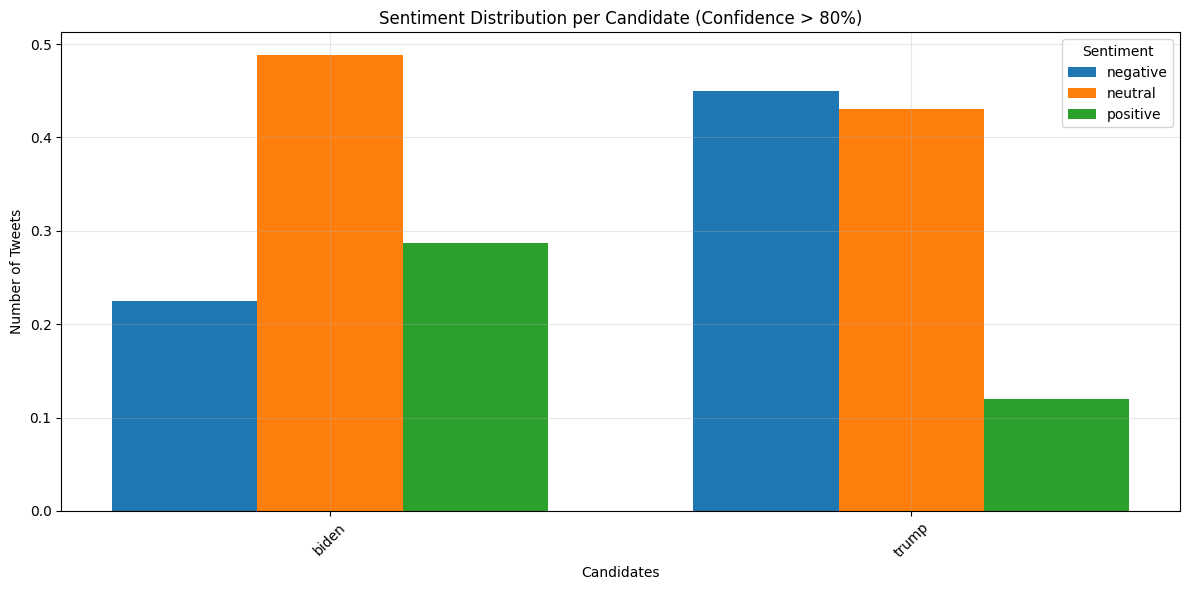

In [218]:
# Let's chart the data by normalized tweet count
sentiment_counts = (tweetALL_sentiments[tweetALL_sentiments['sentiment_score'] > 0.80]
                   .groupby('candidate')['sentiment']
                   .value_counts(normalize=True)
                   .unstack(fill_value=0))

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_counts.index
sentiments = sentiment_counts.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_counts[sentiment], 
            bar_width, 
            label=sentiment)

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Distribution per Candidate (Confidence > 80%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [142]:
print(
    tweetALL_sentiments[tweetALL_sentiments['sentiment_score'] > 0.9]
    .groupby('candidate')['sentiment']
    .value_counts()
    .unstack(fill_value=0)
)

sentiment  negative  neutral  positive
candidate                             
biden         23461    23668     75177
trump         55620    21712     27677


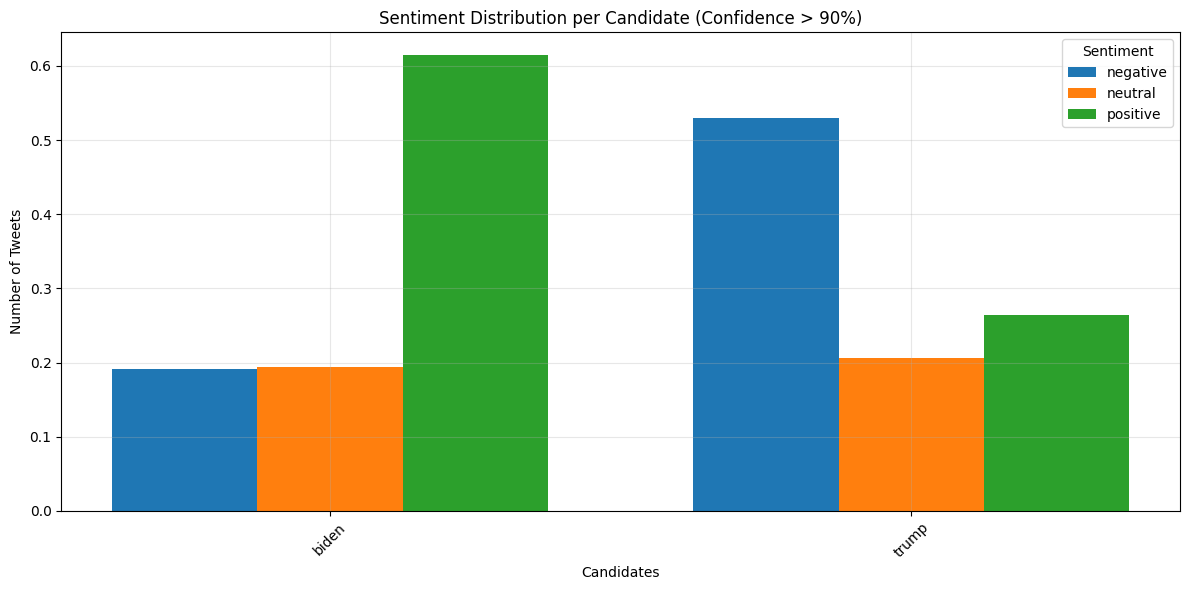

In [217]:
# Let's chart the data by tweet count
sentiment_counts = (tweetALL_sentiments[tweetALL_sentiments['sentiment_score'] > 0.90]
                   .groupby('candidate')['sentiment']
                   .value_counts(normalize=True)
                   .unstack(fill_value=0))

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_counts.index
sentiments = sentiment_counts.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_counts[sentiment], 
            bar_width, 
            label=sentiment)

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Distribution per Candidate (Confidence > 90%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

Since we are looking at the whole dataset here, let's see if there are any significant differences between which countries support either candidate more? We'll take the top ten for now.

In [227]:
# Sentiment by candidate and location
sentimentbyloc_counts = (tweetALL_sentiments[tweetALL_sentiments['sentiment_score'] > 0.80]
                         .groupby(['candidate', 'country'])['sentiment']
                         .value_counts()
                         .unstack(fill_value=0))

In [237]:
print(sentimentbyloc_counts)

sentiment                                   negative  neutral  positive
candidate country                                                      
biden     Afghanistan                              2       28        14
          Albania                                  7       17         1
          Algeria                                  1        6         1
          Angola                                   1       11         3
          Anguilla                                 0        0         2
          Antigua and Barbuda                      2        0         0
          Argentina                               25     1267        65
          Armenia                                  2       19         6
          Australia                              918      687       870
          Austria                                 30      300        70
          Azerbaijan                              51       79        45
          Bahamas                                  1        4   

In [228]:
# Group by candidate and get top 10 countries
top_countries_by_candidate = (sentimentbyloc_counts['positive']
                            .groupby('candidate')
                            .nlargest(10)
                            .reset_index(level=1))  # level=1 keeps country

print(top_countries_by_candidate)

                         candidate  positive
candidate country                           
biden     US                 biden     27424
          United Kingdom     biden      4363
          India              biden      4191
          Canada             biden      1774
          Germany            biden      1173
          Pakistan           biden       938
          Australia          biden       870
          France             biden       831
          Italy              biden       683
          Ireland            biden       602
trump     US                 trump     11661
          United Kingdom     trump      1976
          India              trump      1042
          Canada             trump       677
          Germany            trump       628
          Australia          trump       470
          France             trump       418
          Nigeria            trump       327
          Bangladesh         trump       312
          Brazil             trump       311


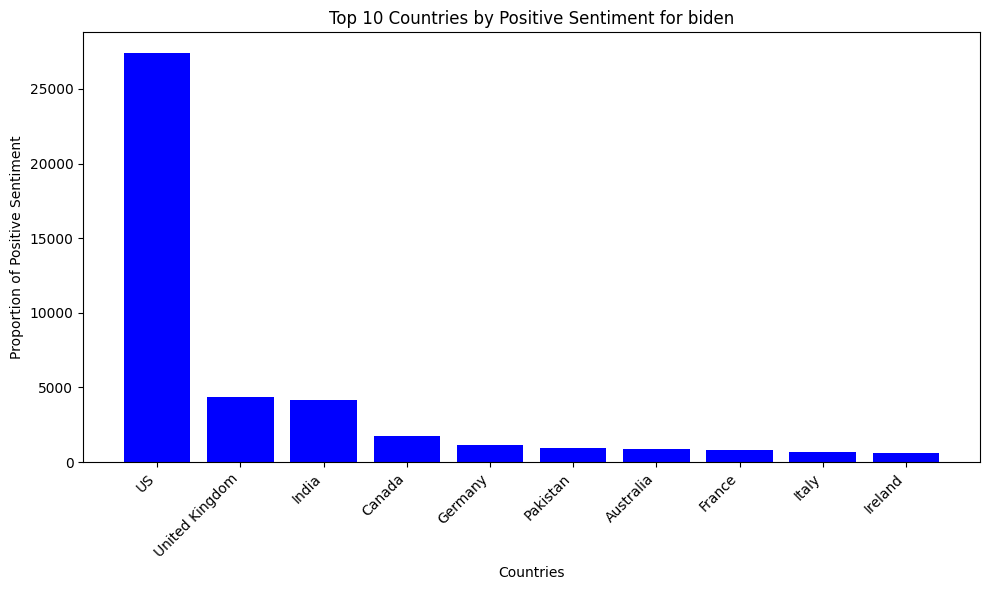

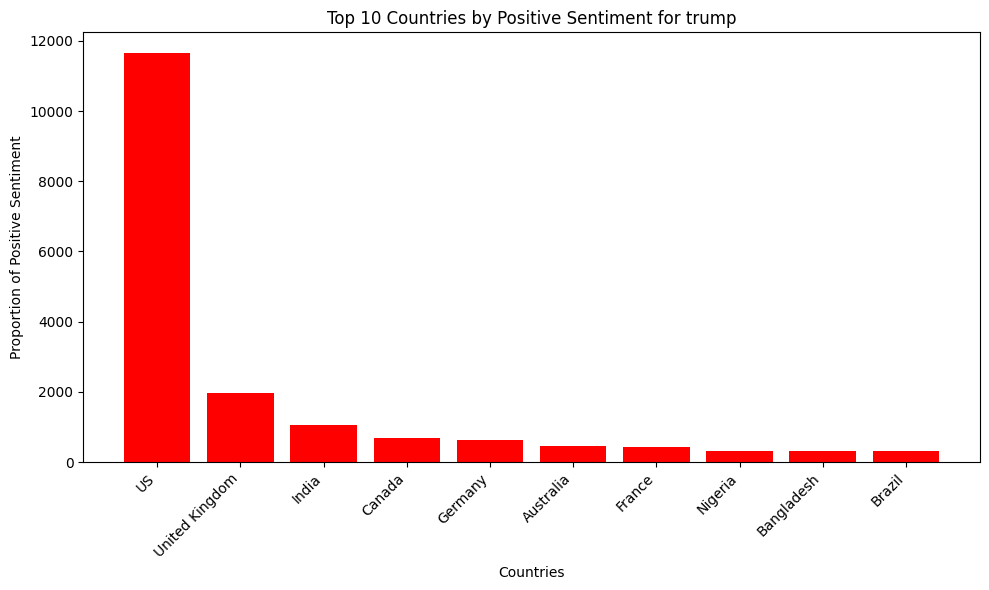

In [234]:
# Get data for each candidate
biden_data = top_countries_by_candidate.loc['biden']
trump_data = top_countries_by_candidate.loc['trump']

# Plot for biden with blue bars
plt.figure(figsize=(10, 6))
plt.bar(biden_data.index, biden_data['positive'], color='blue')  # Blue for Biden
plt.title('Top 10 Countries by Positive Sentiment for biden')
plt.xlabel('Countries')
plt.ylabel('Proportion of Positive Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for trump with red bars
plt.figure(figsize=(10, 6))
plt.bar(trump_data.index, trump_data['positive'], color='red')  # Red for Trump
plt.title('Top 10 Countries by Positive Sentiment for trump')
plt.xlabel('Countries')
plt.ylabel('Proportion of Positive Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()